In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Download the data and create loaders for training and testing.

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


This is the small net. You can use it for debugging purposes.

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 1, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(121, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


net = Net()

This is the big net. Use it when you think you have a bug-free code :)

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

This defines the optimization

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

and runs the training loop:

In [7]:
for epoch in range(1):

    losses = []
    accuracies = []
    avg_losses = []
    avg_accuracies = []
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # Zero the gradients before forward prop
        optimizer.zero_grad()
        
        # forward propagation
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # backward propagation
        loss.backward()
        optimizer.step()
        
        # Save loss and accuracy for current batch
        losses.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        accuracies.append(correct/total)
        
        # Save statistics every 2k batches and display progress
        if i % 2000 == 0:
            avg_losses.append(sum(losses[-2000:])/len(losses[-2000:]))
            avg_accuracies.append(sum(accuracies[-2000:])/len(accuracies[-2000:]))
            
            print(f'Epoch {epoch}, batch {i}')
            

print('Finished Training')

Epoch 0, batch 0
Epoch 0, batch 2000
Epoch 0, batch 4000
Epoch 0, batch 6000
Epoch 0, batch 8000
Epoch 0, batch 10000
Epoch 0, batch 12000
Finished Training


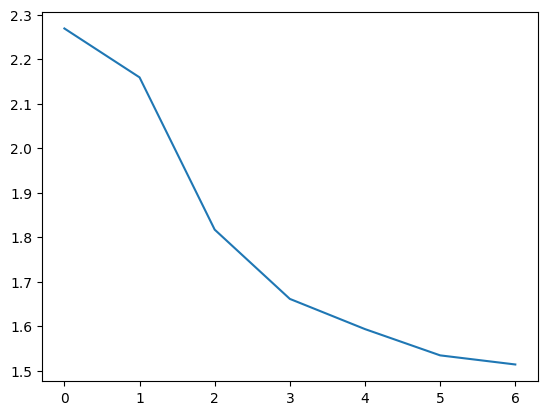

In [8]:
import matplotlib.pyplot as plt

plt.plot(avg_losses)

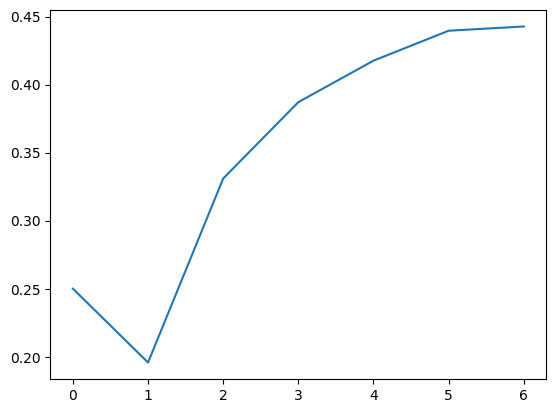

In [9]:
plt.plot(avg_accuracies)

In [10]:
avg_accuracies[-1]

0.44275

Once training is finished, we evaluate performance on the test set.

In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader):
        if i % 1000 == 0:
            print(i)
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

0
1000
2000
Accuracy of the network on the 10000 test images: 23 %


Hm, this is not good. Can you find the bug that's making the test set performance be much worse than the training set performance?